# PACMANN Probability Project - The Effect of Debtors’ Financial State on Credit Approval

## Objectives

- Describe the financial characteristics of loan applicants as a whole and their probability distribution
- Identify the financial condition of loan applicants causing them to be flagged (and thus having their credit application rejected)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 0. Importing data

Data source: https://www.kaggle.com/competitions/GiveMeSomeCredit

In [2]:
credit_data = pd.read_csv("cs-training.csv")
credit_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# 1. Check the data

In [3]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

There are null values in the MonthlyIncome and NumberOfDependents columns.

# 2. Cleaning the data

## 2(a) Treating NumberOfDependents

We will fill the NaN values on NumberOfDependents with its mode.

In [4]:
credit_data["NumberOfDependents"] = credit_data["NumberOfDependents"].fillna(0)

In [5]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

## 2(b) Treating MonthlyIncome

It seems that all customers with NaN MonthlyIncome have integer DebtRatio. But to calculate DebtRatio (which is equal to Monthly Debt Payments/Monthly Income), MonthlyIncome is needed. It is safe to assume that for these NaN MonthlyIncome customers, their DebtRatio is in reality just a rough estimate. 

Moreover, these NaN MonthlyIncome customers have large DebtRatio.

Due to this, we may guess that these customers are actually businesses (with no exact monthly income), and that the customers with available MonthlyIncome are actually personal customers.

In [6]:
null_income = credit_data["MonthlyIncome"].isna()

credit_data["TypeCustomer"] = np.where(null_income, "Business", "Personal")

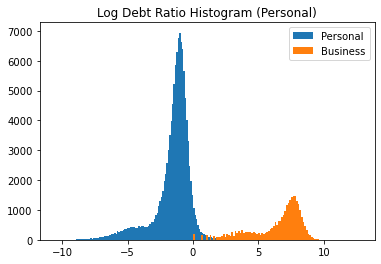

In [7]:
pers = credit_data["TypeCustomer"] == "Personal"
personal = pers
nonzero_dr = credit_data["DebtRatio"] > 0

plt.hist(x=np.log(credit_data[pers & nonzero_dr]["DebtRatio"]), bins=200, label='Personal')
plt.hist(x=np.log(credit_data[~pers & nonzero_dr]["DebtRatio"]), bins=100, label='Business')
plt.legend()
plt.title("Log Debt Ratio Histogram (Personal)")
plt.show()

Now let's try to fix other columns.

## 2(c) Treating NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse & NumberOfTimes90DaysLate

For these columns, there are observations with extremely large values which doesn't make sense.

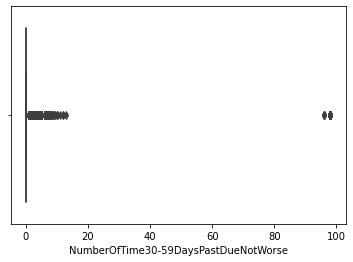

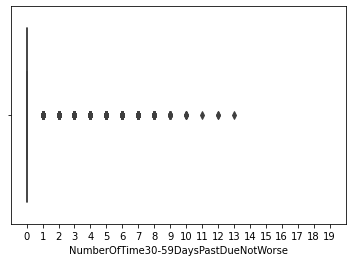

In [8]:
sns.boxplot(data=credit_data, x="NumberOfTime30-59DaysPastDueNotWorse")
plt.show()

sns.boxplot(data=credit_data, x="NumberOfTime30-59DaysPastDueNotWorse")
plt.xlim([-1,20])
plt.xticks(range(20))
plt.show()

In [9]:
large_val = credit_data["NumberOfTime30-59DaysPastDueNotWorse"].max()
large_val

98

In [10]:
credit_data[(credit_data["NumberOfTime30-59DaysPastDueNotWorse"] > 95) & (credit_data["NumberOfTime30-59DaysPastDueNotWorse"] < 98)]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TypeCustomer
41944,41945,1,1.0,26,96,0.000000,NaN,0,96,0,96,0.0,Business
69478,69479,1,1.0,33,96,0.008047,4100.0,0,96,0,96,0.0,Personal
84167,84168,1,1.0,29,96,0.000000,2800.0,0,96,0,96,2.0,Personal
94106,94107,1,1.0,34,96,0.000000,3500.0,0,96,0,96,1.0,Personal
120049,120050,0,1.0,46,96,0.051765,4616.0,0,96,0,96,0.0,Personal


In [11]:
large_val_obs = credit_data["NumberOfTime30-59DaysPastDueNotWorse"] > 20
credit_data[large_val_obs]["age"].min()

21

It doesn't make any sense for a 21-year-old to have 98 times of 30-59 days past payments $98\times 30/365 = 8.05$; it doesn't make sense for a 21-year-old to have started making credit payment from the age 13. 

For these type of observations, we impute these large values with the mode (which is 0).

In [12]:
credit_data["NumberOfTime30-59DaysPastDueNotWorse"] = np.where(credit_data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
                                                               0, 
                                                               credit_data["NumberOfTime30-59DaysPastDueNotWorse"])

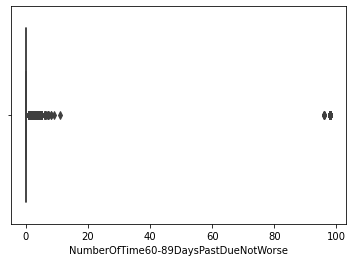

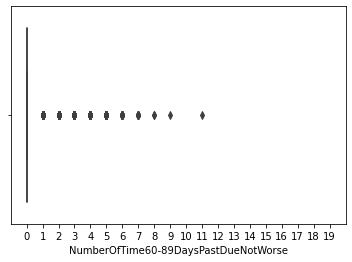

In [13]:
sns.boxplot(data=credit_data, x="NumberOfTime60-89DaysPastDueNotWorse")
plt.show()

sns.boxplot(data=credit_data, x="NumberOfTime60-89DaysPastDueNotWorse")
plt.xlim([-1,20])
plt.xticks(range(20))
plt.show()

In [14]:
credit_data["NumberOfTime60-89DaysPastDueNotWorse"] = np.where(credit_data["NumberOfTime60-89DaysPastDueNotWorse"] > 20,
                                                               0, 
                                                               credit_data["NumberOfTime60-89DaysPastDueNotWorse"])

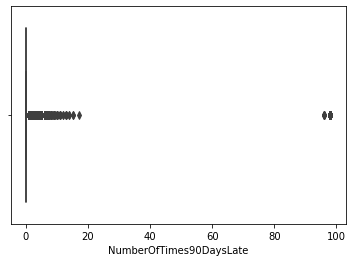

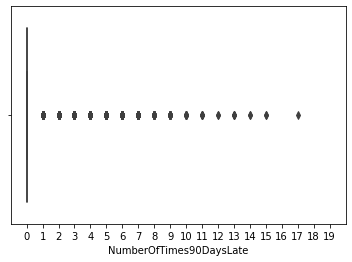

In [15]:
sns.boxplot(data=credit_data, x="NumberOfTimes90DaysLate")
plt.show()

sns.boxplot(data=credit_data, x="NumberOfTimes90DaysLate")
plt.xlim([-1,20])
plt.xticks(range(20))
plt.show()

In [16]:
credit_data["NumberOfTimes90DaysLate"] = np.where(credit_data["NumberOfTimes90DaysLate"] > 20,
                                                  0, 
                                                  credit_data["NumberOfTimes90DaysLate"])

## 2(d) Treating Age

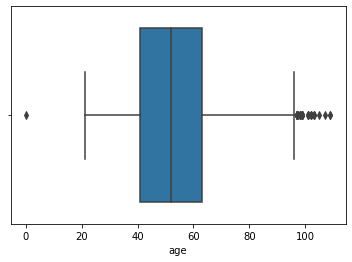

In [17]:
sns.boxplot(data=credit_data, x="age")
plt.show()

In [18]:
credit_data[credit_data["age"]==0]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TypeCustomer
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0,Personal


It doesn't make sense for a newborn baby to have a monthly income & open credit lines. So we impute this age value with the median.

In [19]:
age_median = credit_data["age"].median()
credit_data["age"].replace(0, age_median, inplace=True)

# 3. Descriptive Statistics

In [20]:
col =  ['NumberOfOpenCreditLinesAndLoans',
        'NumberRealEstateLoansOrLines',
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfTimes90DaysLate',
        'RevolvingUtilizationOfUnsecuredLines',
        'DebtRatio',
        'MonthlyIncome']

credit_data[col].describe().T

,count,mean,std,min,25%,50%,75%,max
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.245353,0.697231,0.0,0.000000,0.000000,0.000000,13.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.064707,0.329788,0.0,0.000000,0.000000,0.000000,11.0
NumberOfTimes90DaysLate,150000.0,0.090293,0.485107,0.0,0.000000,0.000000,0.000000,17.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0


# 4. Discrete Features Analysis

In [21]:
discrete = ['SeriousDlqin2yrs',
            'NumberOfOpenCreditLinesAndLoans',
            'NumberOfDependents',
            'NumberRealEstateLoansOrLines',
            'NumberOfTime30-59DaysPastDueNotWorse',
            'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate']

credit_data[discrete].describe()

,SeriousDlqin2yrs,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,8.452760,0.737413,1.018240,0.245353,0.064707,0.090293
std,0.249746,5.145951,1.107021,1.129771,0.697231,0.329788,0.485107
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,11.000000,1.000000,2.000000,0.000000,0.000000,0.000000
max,1.000000,58.000000,20.000000,54.000000,13.000000,11.000000,17.000000


## 4(a) SeriousDlqin2yrs & TypeCustomer

The SeriousDlqin2yrs column described whether a customer is flagged (labeled 1) for experiencing 90 days past due delinquency or worse in the last 2 years.

The TypeCustomer column is derived from MonthlyIncome; if MonthlyIncome is NaN-valued, then the TypeCustomer is 'Business', otherwise 'Personal'.

In [22]:
flagged = (credit_data["SeriousDlqin2yrs"] == 1)
prob_flagged = flagged.mean()

print(f"Probability of Being Flagged = {prob_flagged}")

Probability of Being Flagged = 0.06684


In [23]:
pers = (credit_data["TypeCustomer"] == 'Personal')
prob_pers = pers.mean()
bus = (credit_data["TypeCustomer"] == 'Business')
prob_bus = bus.mean()

print(f"Probability of \'Personal\' Customer Type = {prob_pers}")
print(f"Probability of \'Business\' Customer Type = {prob_bus}")

Probability of 'Personal' Customer Type = 0.8017933333333334
Probability of 'Business' Customer Type = 0.19820666666666667


## 4(b) NumberOfOpenCreditLinesAndLoans

<AxesSubplot:xlabel='NumberOfOpenCreditLinesAndLoans'>

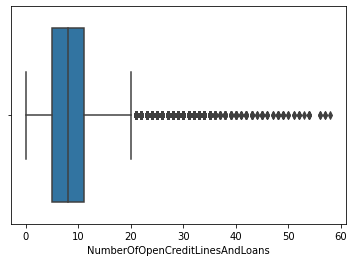

In [24]:
sns.boxplot(data=credit_data, x="NumberOfOpenCreditLinesAndLoans")

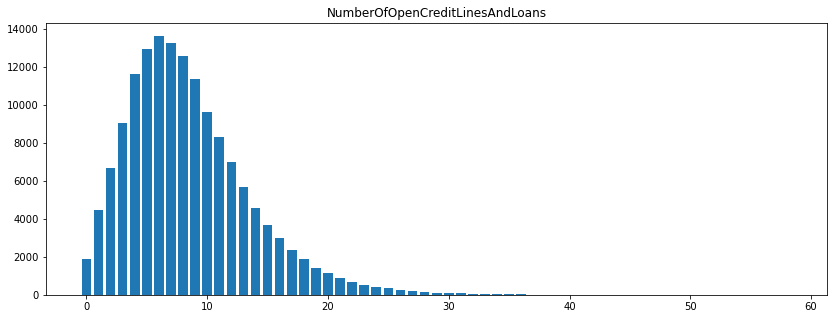

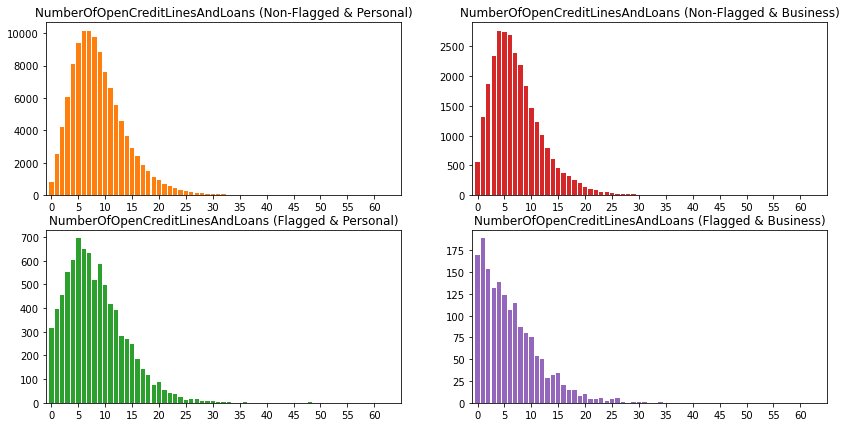

In [25]:
plt.figure(figsize=(14,5))
plt.bar(*np.unique(credit_data["NumberOfOpenCreditLinesAndLoans"], return_counts=True))
plt.title("NumberOfOpenCreditLinesAndLoans")
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers]["NumberOfOpenCreditLinesAndLoans"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberOfOpenCreditLinesAndLoans (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers]["NumberOfOpenCreditLinesAndLoans"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberOfOpenCreditLinesAndLoans (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers]["NumberOfOpenCreditLinesAndLoans"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberOfOpenCreditLinesAndLoans (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers]["NumberOfOpenCreditLinesAndLoans"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberOfOpenCreditLinesAndLoans (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,65])
    axes.set_xticks(np.arange(0,65,5))

plt.show()


It seems that the distribution of NumberOfOpenCreditLinesAndLoans is shifted to the left if the customer is flagged (experienced 90 days past due delinquency or worse)

In [26]:
credit_data["NumberOfOpenCreditLinesAndLoans"].median()

8.0

In [27]:
zero_num_cred_lines = (credit_data["NumberOfOpenCreditLinesAndLoans"] == 0)
prob_zero_num_cred_lines = zero_num_cred_lines.mean()
prob_flagged = flagged.mean()

print(f"Probability of Zero Number of Credit Lines = {prob_zero_num_cred_lines}")
print(f"Probability of Flagged = {prob_flagged}\n")

p1 = (zero_num_cred_lines & flagged).mean()/(flagged).mean()
print(f"Probability of Zero Num of Cred Lines, conditioned on Flagged = {p1}")

p2 = (zero_num_cred_lines & flagged).mean()/(zero_num_cred_lines).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Cred Lines = {p2}\n")

p3 = (zero_num_cred_lines & flagged & personal).mean()/(flagged & personal).mean()
print(f"Probability of Zero Num of Cred Lines, conditioned on Flagged & Personal = {p3}")

p4 = (zero_num_cred_lines & flagged & personal).mean()/(zero_num_cred_lines & personal).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Cred Lines & Personal = {p4}\n")

p5 = (zero_num_cred_lines & flagged & ~personal).mean()/(flagged & ~personal).mean()
print(f"Probability of Zero Num of Cred Lines, conditioned on Flagged & Business = {p5}")

p6 = (zero_num_cred_lines & flagged & ~personal).mean()/(zero_num_cred_lines & ~personal).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Cred Lines & Business = {p6}\n")


Probability of Zero Number of Credit Lines = 0.012586666666666666
Probability of Flagged = 0.06684

Probability of Zero Num of Cred Lines, conditioned on Flagged = 0.04827448633552763
Probability of Flagged, conditioned on Zero Num of Cred Lines = 0.25635593220338987

Probability of Zero Num of Cred Lines, conditioned on Flagged & Personal = 0.037573291851142755
Probability of Flagged, conditioned on Zero Num of Cred Lines & Personal = 0.27162629757785467

Probability of Zero Num of Cred Lines, conditioned on Flagged & Business = 0.1018573996405033
Probability of Flagged, conditioned on Zero Num of Cred Lines & Business = 0.23224043715846998



From the results above, the odds that a customer is flagged will increase four times if they have zero number of open credit lines and loans.

## 4(c) NumberOfDependents

<AxesSubplot:xlabel='NumberOfDependents'>

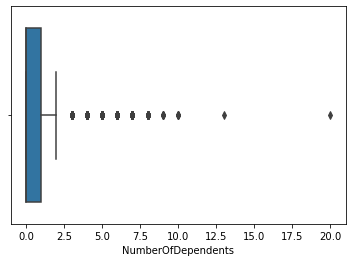

In [28]:
sns.boxplot(data=credit_data, x="NumberOfDependents")

In [29]:
credit_data[credit_data["NumberOfDependents"] > 15]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TypeCustomer
6299,6300,0,0.226616,40,1,0.576539,6316.0,11,2,1,0,20.0,Personal


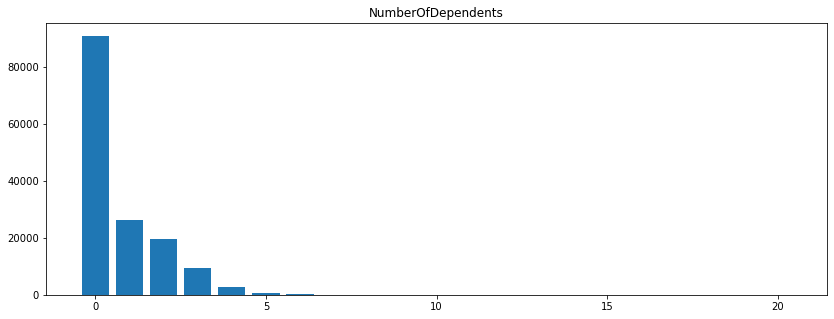

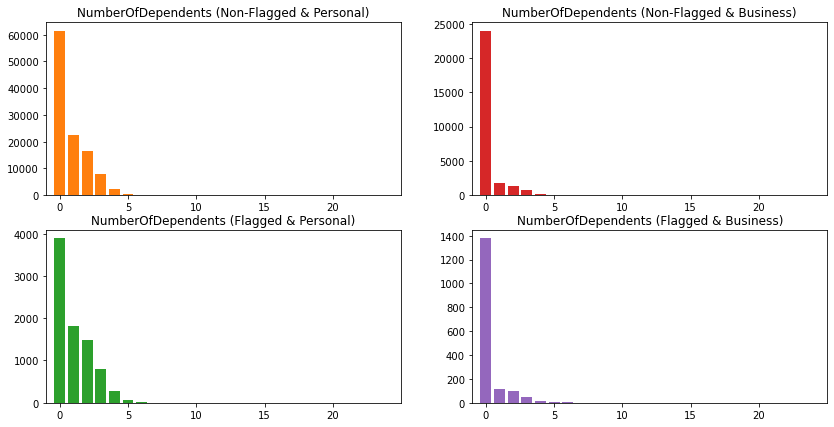

In [30]:
plt.figure(figsize=(14,5))
plt.bar(*np.unique(credit_data["NumberOfDependents"], return_counts=True))
plt.title("NumberOfDependents")
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers]["NumberOfDependents"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberOfDependents (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers]["NumberOfDependents"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberOfDependents (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers]["NumberOfDependents"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberOfDependents (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers]["NumberOfDependents"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberOfDependents (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,25])
    axes.set_xticks(np.arange(0,25,5))

plt.show()

In [31]:
zero_num_depend = (credit_data["NumberOfDependents"] == 0)

prob_zero_num_depend = zero_num_depend.mean()
prob_flagged = flagged.mean()
print(f"Probability of Zero Number of Dependents = {prob_zero_num_depend}")
print(f"Probability of Flagged = {prob_flagged}\n")

p2 = (zero_num_depend & flagged).mean()/(zero_num_depend).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Dependents = {p2}\n")

p4 = (zero_num_depend & flagged & personal).mean()/(zero_num_depend & personal).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Dependents & Personal = {p4}\n")

p6 = (zero_num_depend & flagged & ~personal).mean()/(zero_num_depend & ~personal).mean()
print(f"Probability of Flagged, conditioned on Zero Num of Dependents & Business = {p6}\n")


Probability of Zero Number of Dependents = 0.6055066666666666
Probability of Flagged = 0.06684

Probability of Flagged, conditioned on Zero Num of Dependents = 0.05806707330500077

Probability of Flagged, conditioned on Zero Num of Dependents & Personal = 0.05949034465900758

Probability of Flagged, conditioned on Zero Num of Dependents & Business = 0.05439495467087111



From the result above, having zero number of dependents doesn't really change the odds of being flagged.

## 4(d) NumberRealEstateLoansOrLines

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines'>

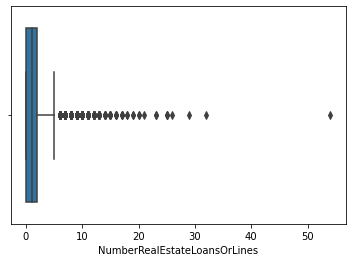

In [32]:
greater_5 = credit_data["NumberRealEstateLoansOrLines"] > 5

sns.boxplot(data=credit_data, x="NumberRealEstateLoansOrLines")

In [33]:
greater_5.mean()

0.005286666666666667

In [34]:
greater_50 = credit_data["NumberRealEstateLoansOrLines"] > 50

credit_data[greater_5]["SeriousDlqin2yrs"].mean()

0.17906683480453972

In [35]:
estate_mean = credit_data[~greater_5]["NumberRealEstateLoansOrLines"].mean()
estate_var = credit_data[~greater_5]["NumberRealEstateLoansOrLines"].var()

print(f'''Excluding the outlier (>5),
Mean of NumberRealEstateLoansOrLines = {estate_mean}
Variance of NumberRealEstateLoansOrLines = {estate_var}''')

Excluding the outlier (>5),
Mean of NumberRealEstateLoansOrLines = 0.981234124404351
Variance of NumberRealEstateLoansOrLines = 0.9611641324627219


In [36]:
from scipy.special import factorial
from numpy import exp

x_range = np.array([n for n in range(6)])
lambd = estate_mean
poi_pmf = np.array([(lambd**n)*exp(-lambd)/factorial(n) for n in range(6)])
poi_count = 150_000*poi_pmf

In [37]:
poi_count

array([56227.23059382, 55172.07737941, 27068.36251947,  8853.46699862,
        2171.83098458,   426.2149349 ])

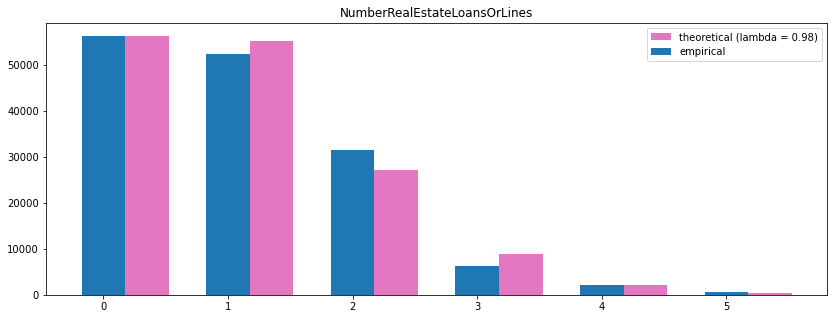

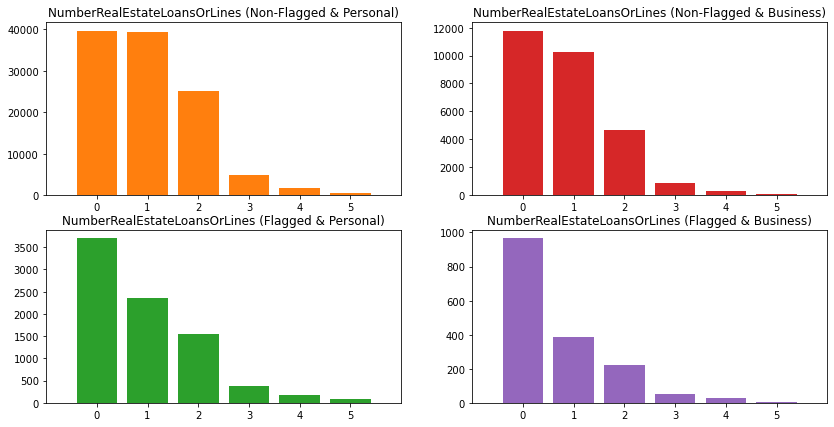

In [38]:
plt.figure(figsize=(14,5))
bar_width = 0.35
plt.bar(*(x_range+bar_width, poi_count), color='C6', width=bar_width, 
        label=f'theoretical (lambda = {lambd:1.2f})')
plt.bar(*np.unique(credit_data[~greater_5]["NumberRealEstateLoansOrLines"], return_counts=True), 
        width=bar_width, label='empirical')
plt.title("NumberRealEstateLoansOrLines")
plt.legend()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers & ~greater_5]["NumberRealEstateLoansOrLines"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberRealEstateLoansOrLines (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers & ~greater_5]["NumberRealEstateLoansOrLines"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberRealEstateLoansOrLines (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers & ~greater_5]["NumberRealEstateLoansOrLines"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberRealEstateLoansOrLines (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers & ~greater_5]["NumberRealEstateLoansOrLines"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberRealEstateLoansOrLines (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,6])
    axes.set_xticks(np.arange(0,6,1))

plt.show()

In [39]:
zero_num_real_est = (credit_data["NumberRealEstateLoansOrLines"] == 0)

prob_greater_5 = greater_5.mean()
prob_flagged = flagged.mean()
print(f"Probability of >5 Number of Real Est. Loans = {prob_greater_5}")
print(f"Probability of Flagged = {prob_flagged}\n")

p2 = (greater_5 & flagged).mean()/(greater_5).mean()
print(f"Probability of Flagged, conditioned on >5 Num of Real Est. Loans = {p2}\n")

p4 = (greater_5 & flagged & personal).mean()/(greater_5 & personal).mean()
print(f"Probability of Flagged, conditioned on >5 Num of Real Est. Loans & Personal = {p4}\n")

p6 = (greater_5 & flagged & ~personal).mean()/(greater_5 & ~personal).mean()
print(f"Probability of Flagged, conditioned on >5 Num of Real Est. Loans & Business = {p6}\n")


Probability of >5 Number of Real Est. Loans = 0.005286666666666667
Probability of Flagged = 0.06684

Probability of Flagged, conditioned on >5 Num of Real Est. Loans = 0.1790668348045397

Probability of Flagged, conditioned on >5 Num of Real Est. Loans & Personal = 0.19264705882352942

Probability of Flagged, conditioned on >5 Num of Real Est. Loans & Business = 0.09734513274336283



## 4(e) NumberOfTime30-59DaysPastDueNotWorse

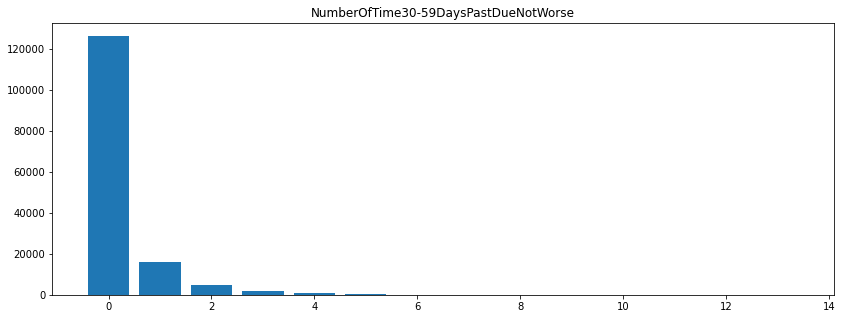

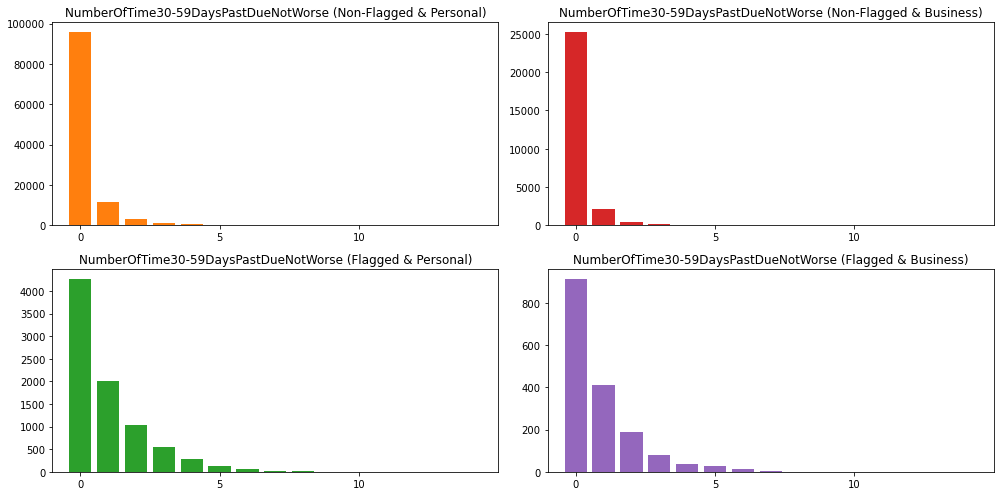

In [40]:
plt.figure(figsize=(14,5))
plt.bar(*np.unique(credit_data["NumberOfTime30-59DaysPastDueNotWorse"], return_counts=True))
plt.title("NumberOfTime30-59DaysPastDueNotWorse")
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers]["NumberOfTime30-59DaysPastDueNotWorse"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberOfTime30-59DaysPastDueNotWorse (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers]["NumberOfTime30-59DaysPastDueNotWorse"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberOfTime30-59DaysPastDueNotWorse (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers]["NumberOfTime30-59DaysPastDueNotWorse"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberOfTime30-59DaysPastDueNotWorse (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers]["NumberOfTime30-59DaysPastDueNotWorse"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberOfTime30-59DaysPastDueNotWorse (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,15])
    axes.set_xticks(np.arange(0,15,5))

fig.tight_layout()
plt.show()

It seems that the distribution of NumberOfTime30-59DaysPastDueNotWorse is shifted to the right if the customer is flagged (experienced 90 days past due delinquency or worse)

In [41]:
nonzero_num_3059_past = (credit_data["NumberOfTime30-59DaysPastDueNotWorse"] >= 1)

prob_nonzero_num_3059_past = nonzero_num_3059_past.mean()
prob_flagged = flagged.mean()
print(f"Probability of Nonzero Number of 30-59 Days Past Due = {prob_nonzero_num_3059_past}")
print(f"Probability of Flagged = {prob_flagged}\n")

p2 = (nonzero_num_3059_past & flagged).mean()/(nonzero_num_3059_past).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due = {p2}\n")

p4 = (nonzero_num_3059_past & flagged & personal).mean()/(nonzero_num_3059_past & personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due & Personal = {p4}\n")

p6 = (nonzero_num_3059_past & flagged & ~personal).mean()/(nonzero_num_3059_past & ~personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due & Business = {p6}\n")


Probability of Nonzero Number of 30-59 Days Past Due = 0.15808666666666665
Probability of Flagged = 0.06684

Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due = 0.20402310968666978

Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due & Personal = 0.20262021735894004

Probability of Flagged, conditioned on Nonzero Num of 30-59 Days Past Due & Business = 0.2119595732734419



From the results above, the odds that a customer will be flagged is more than tripled if they have at least experienced 30-59 past due payments once.

## 4(f) NumberOfTime60-89DaysPastDueNotWorse

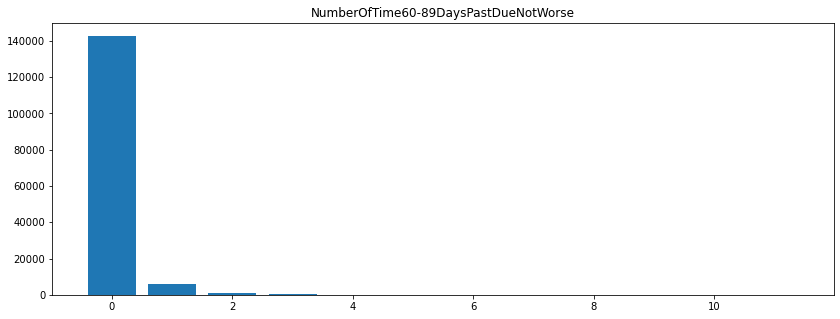

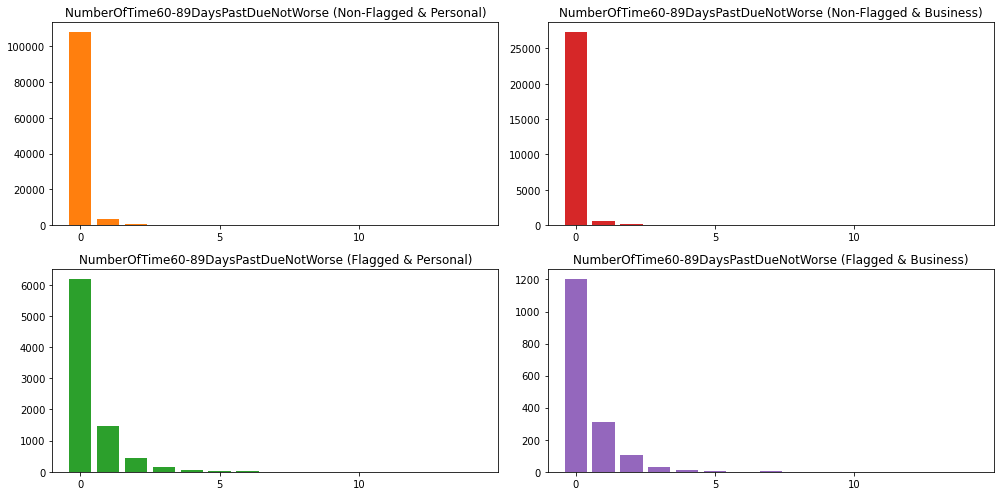

In [42]:
plt.figure(figsize=(14,5))
plt.bar(*np.unique(credit_data["NumberOfTime60-89DaysPastDueNotWorse"], return_counts=True))
plt.title("NumberOfTime60-89DaysPastDueNotWorse")
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers]["NumberOfTime60-89DaysPastDueNotWorse"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberOfTime60-89DaysPastDueNotWorse (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers]["NumberOfTime60-89DaysPastDueNotWorse"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberOfTime60-89DaysPastDueNotWorse (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers]["NumberOfTime60-89DaysPastDueNotWorse"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberOfTime60-89DaysPastDueNotWorse (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers]["NumberOfTime60-89DaysPastDueNotWorse"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberOfTime60-89DaysPastDueNotWorse (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,15])
    axes.set_xticks(np.arange(0,15,5))

fig.tight_layout()
plt.show()

In [43]:
nonzero_num_6089_past = (credit_data["NumberOfTime60-89DaysPastDueNotWorse"] >= 1)

prob_nonzero_num_6089_past = nonzero_num_6089_past.mean()
prob_flagged = flagged.mean()
print(f"Probability of Nonzero Number of 60-89 Days Past Due = {prob_nonzero_num_6089_past}")
print(f"Probability of Flagged = {prob_flagged}\n")

p2 = (nonzero_num_6089_past & flagged).mean()/(nonzero_num_6089_past).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due = {p2}\n")

p4 = (nonzero_num_6089_past & flagged & personal).mean()/(nonzero_num_6089_past & personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due & Personal = {p4}\n")

p6 = (nonzero_num_6089_past & flagged & ~personal).mean()/(nonzero_num_6089_past & ~personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due & Business = {p6}\n")


Probability of Nonzero Number of 60-89 Days Past Due = 0.0489
Probability of Flagged = 0.06684

Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due = 0.3576005453306067

Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due & Personal = 0.3523747347804798

Probability of Flagged, conditioned on Nonzero Num of 60-89 Days Past Due & Business = 0.3841059602649007



From the results above, the odds that a customer will be flagged is increased six times if they have at least experienced 60-89 days past due payments once.

## 4(g) NumberOfTimes90DaysLate

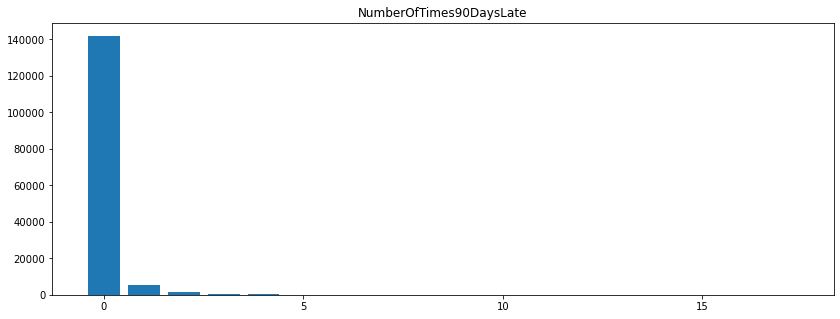

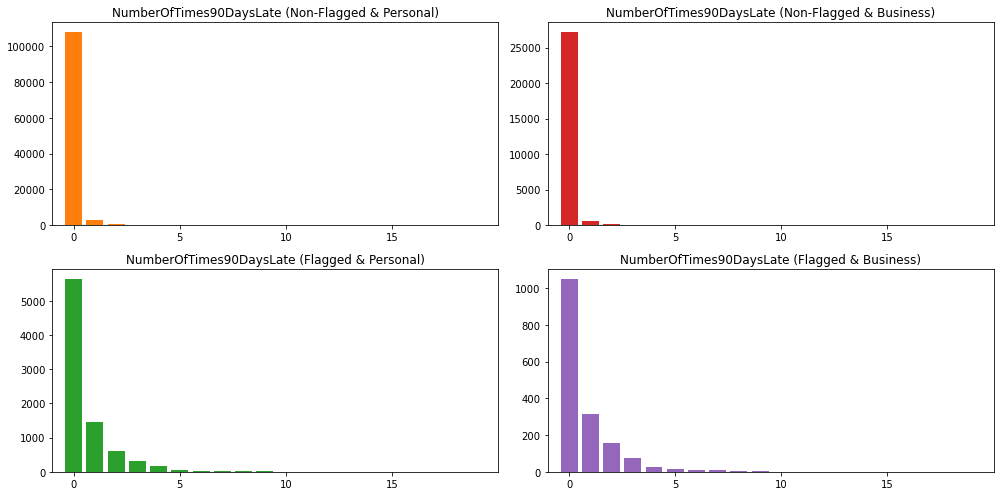

In [44]:
plt.figure(figsize=(14,5))
plt.bar(*np.unique(credit_data["NumberOfTimes90DaysLate"], return_counts=True))
plt.title("NumberOfTimes90DaysLate")
plt.xticks(np.arange(0,20,5))
plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,7))

ax[0,0].bar(*np.unique(credit_data[~flagged & pers]["NumberOfTimes90DaysLate"], return_counts=True),
           color='C1')
ax[0,0].set_title("NumberOfTimes90DaysLate (Non-Flagged & Personal)")

ax[1,0].bar(*np.unique(credit_data[flagged & pers]["NumberOfTimes90DaysLate"], return_counts=True),
           color='C2')
ax[1,0].set_title("NumberOfTimes90DaysLate (Flagged & Personal)")

ax[0,1].bar(*np.unique(credit_data[~flagged & ~pers]["NumberOfTimes90DaysLate"], return_counts=True),
           color='C3')
ax[0,1].set_title("NumberOfTimes90DaysLate (Non-Flagged & Business)")

ax[1,1].bar(*np.unique(credit_data[flagged & ~pers]["NumberOfTimes90DaysLate"], return_counts=True),
           color='C4')
ax[1,1].set_title("NumberOfTimes90DaysLate (Flagged & Business)")

for axes in ax.reshape(-1):
    axes.set_xlim([-1,20])
    axes.set_xticks(np.arange(0,20,5))

fig.tight_layout()
plt.show()

In [45]:
nonzero_num_90_past = (credit_data["NumberOfTimes90DaysLate"] >= 1)

prob_nonzero_num_90_past = nonzero_num_90_past.mean()
prob_flagged = flagged.mean()
print(f"Probability of Nonzero Number of >=90 Days Past Due = {prob_nonzero_num_90_past}")
print(f"Probability of Flagged = {prob_flagged}\n")

p2 = (nonzero_num_90_past & flagged).mean()/(nonzero_num_90_past).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of >= 90 Days Past Due = {p2}\n")

p4 = (nonzero_num_90_past & flagged & personal).mean()/(nonzero_num_90_past & personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of >=90 Days Past Due & Personal = {p4}\n")

p6 = (nonzero_num_90_past & flagged & ~personal).mean()/(nonzero_num_90_past & ~personal).mean()
print(f"Probability of Flagged, conditioned on Nonzero Num of >= 90 Days Past Due & Business = {p6}\n")


Probability of Nonzero Number of >=90 Days Past Due = 0.05379333333333333
Probability of Flagged = 0.06684

Probability of Flagged, conditioned on Nonzero Num of >= 90 Days Past Due = 0.41207088858594626

Probability of Flagged, conditioned on Nonzero Num of >=90 Days Past Due & Personal = 0.41158582940550403

Probability of Flagged, conditioned on Nonzero Num of >= 90 Days Past Due & Business = 0.4142091152815014



From the results above, the odds that a customer will be flagged is increased seven times if they have at least experienced >=90 days past due payments once.

# 5. Continuous Features Analysis

In [46]:
credit_data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'TypeCustomer'],
      dtype='object')

In [47]:
continuous = ['DebtRatio',
              'RevolvingUtilizationOfUnsecuredLines',
              'MonthlyIncome',
              'age']

credit_data[continuous].describe()

,DebtRatio,RevolvingUtilizationOfUnsecuredLines,MonthlyIncome,age
count,150000.000000,150000.000000,1.202690e+05,150000.000000
mean,353.005076,6.048438,6.670221e+03,52.295553
std,2037.818523,249.755371,1.438467e+04,14.771249
min,0.000000,0.000000,0.000000e+00,21.000000
25%,0.175074,0.029867,3.400000e+03,41.000000
50%,0.366508,0.154181,5.400000e+03,52.000000
75%,0.868254,0.559046,8.249000e+03,63.000000
max,329664.000000,50708.000000,3.008750e+06,109.000000


## 5(a) Debt Ratio

In [48]:
nonzero_dr = credit_data["DebtRatio"] > 0
nonzero_dr.mean()

0.97258

In [49]:
(~nonzero_dr).sum()

4113

In [50]:
p1 = (~nonzero_dr & pers).mean()/(pers).mean()

print(f"Probability of zero DebtRatio given customer type Personal = {p1}")

p2 = (~nonzero_dr & ~pers).mean()/(~pers).mean()

print(f"Probability of zero DebtRatio given customer type Business = {p2}")

Probability of zero DebtRatio given customer type Personal = 0.020711904148201114
Probability of zero DebtRatio given customer type Business = 0.05455585079546601


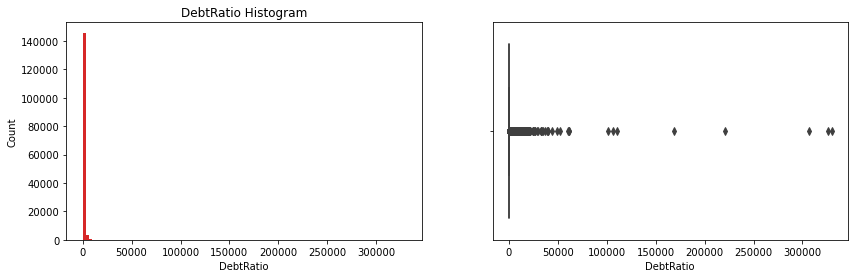

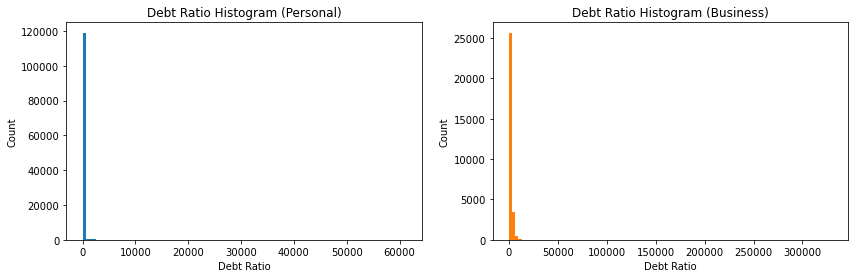

In [51]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(credit_data["DebtRatio"], bins = 100, color='C3')
ax[0].set_title("DebtRatio Histogram")
ax[0].set_xlabel("DebtRatio")
ax[0].set_ylabel("Count")

ax[1] = sns.boxplot(data=credit_data, x='DebtRatio')

plt.show()

fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(credit_data[pers]["DebtRatio"], bins = 100, color='C0')
ax[0].set_title("Debt Ratio Histogram (Personal)")

ax[1].hist(credit_data[~pers]["DebtRatio"], bins = 100, color='C1')
ax[1].set_title("Debt Ratio Histogram (Business)")

for j in range(2):
    ax[j].set_xlabel("Debt Ratio")
    ax[j].set_ylabel("Count")
    
plt.show()

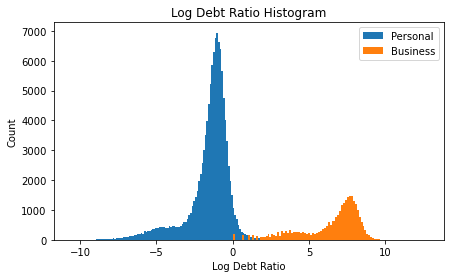

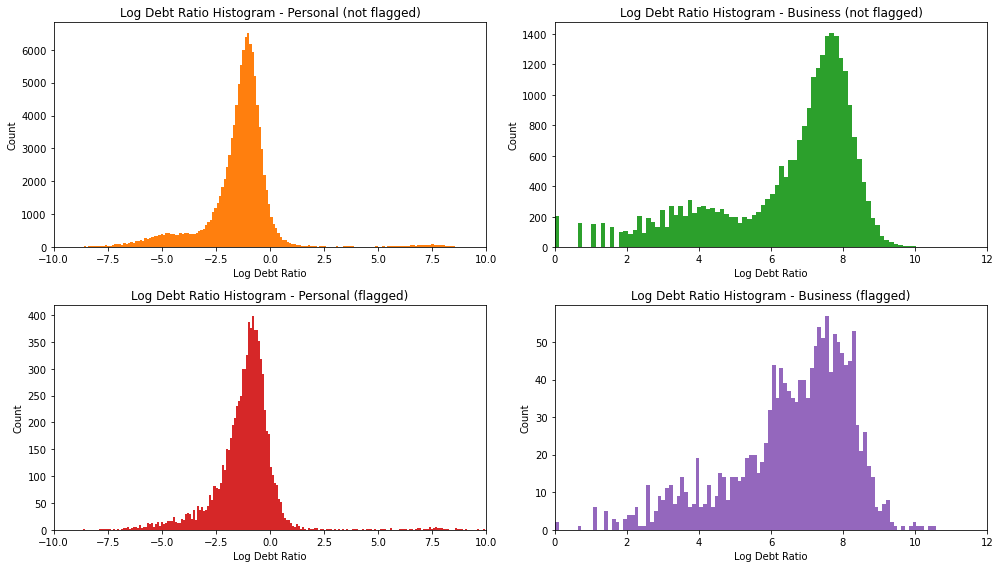

In [52]:
plt.figure(figsize=(7,4))
plt.hist(np.log(credit_data[nonzero_dr & pers]["DebtRatio"]), bins = 200, label='Personal')
plt.hist(np.log(credit_data[nonzero_dr & ~pers]["DebtRatio"]), bins = 100, label='Business')
plt.title("Log Debt Ratio Histogram")
plt.xlabel("Log Debt Ratio")
plt.ylabel("Count")
plt.legend()

plt.show()

fig, ax = plt.subplots(2,2, figsize=(14,8))

ax[0,0].hist(np.log(credit_data[nonzero_dr & pers & ~flagged]["DebtRatio"]), bins = 200, color='C1')
ax[0,0].set_title("Log Debt Ratio Histogram - Personal (not flagged)")

ax[0,1].hist(np.log(credit_data[nonzero_dr & ~pers & ~flagged]["DebtRatio"]), bins = 100, color = 'C2')
ax[0,1].set_title("Log Debt Ratio Histogram - Business (not flagged)")

ax[1,0].hist(np.log(credit_data[nonzero_dr & pers & flagged]["DebtRatio"]), bins = 200, color='C3')
ax[1,0].set_title("Log Debt Ratio Histogram - Personal (flagged)")

ax[1,1].hist(np.log(credit_data[nonzero_dr & ~pers & flagged]["DebtRatio"]), bins = 100, color = 'C4')
ax[1,1].set_title("Log Debt Ratio Histogram - Business (flagged)")

for axes in ax.reshape(-1):
    axes.set_xlabel("Log Debt Ratio")
    axes.set_ylabel("Count")
    
for j in range(2):
    ax[j,0].set_xlim([-10,10])
    ax[j,1].set_xlim([-0,12])

fig.tight_layout()
plt.show()

In [53]:
prob_zero_dr = (~nonzero_dr).mean()

print(f'Probability of 0 DebtRatio: {prob_zero_dr}')

Probability of 0 DebtRatio: 0.02742


In [54]:
from scipy.stats import norm

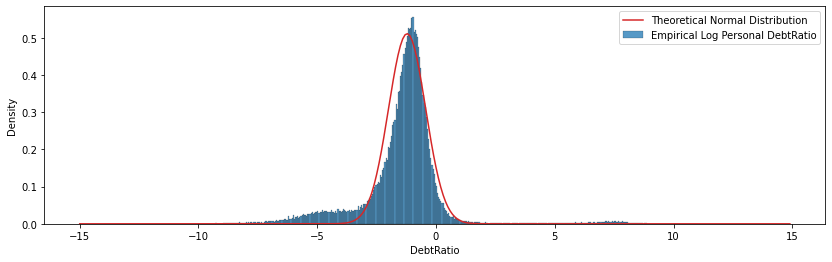

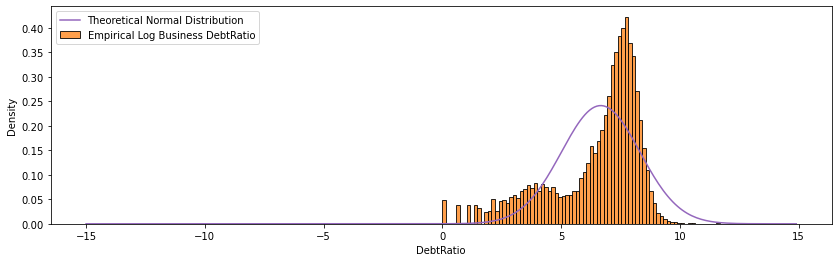

In [55]:
for k, cust in enumerate(["Personal", "Business"]):
    
    cust_type = (credit_data["TypeCustomer"] == cust)

    log_debtratio = np.log(credit_data[nonzero_dr & cust_type]["DebtRatio"])

    q1 = log_debtratio.quantile(0.25)
    q3 = log_debtratio.quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR

    p1 = log_debtratio.quantile(0.025)
    p2 = log_debtratio.quantile(0.975)

    inside_whisker = (log_debtratio > lower) & (log_debtratio < upper)

    # create normal distribution plot

    x_axis = np.arange(-15, 15, 0.1)

    mean = log_debtratio[inside_whisker].mean()
    sd = log_debtratio[inside_whisker].std()

    plt.figure(figsize=(14,4))    
    sns.histplot(x=log_debtratio, stat='density', color=f'C{k}', label=f'Empirical Log {cust} DebtRatio')
    plt.plot(x_axis, norm.pdf(x_axis, mean, sd), color=f'C{k+3}', label='Theoretical Normal Distribution')
    plt.legend()
    plt.show()

In [56]:
print(f'Mean of Normal Distribution: {mean:1.2f}')
print(f'Standard Deviation of Normal Distribution: {sd:1.2f}')

Mean of Normal Distribution: 6.67
Standard Deviation of Normal Distribution: 1.65


## 5(b) RevolvingUtilizationOfUnsecuredLines

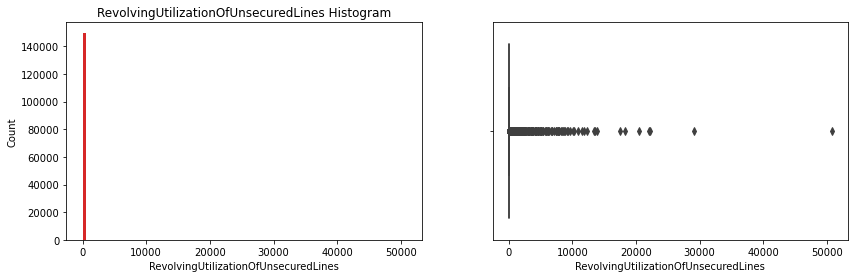

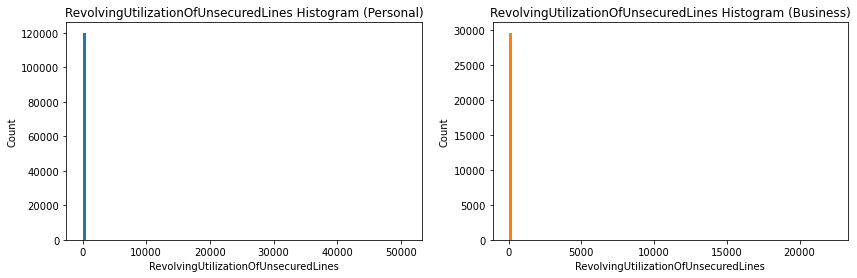

In [57]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(credit_data["RevolvingUtilizationOfUnsecuredLines"], bins = 100, color='C3')
ax[0].set_title("RevolvingUtilizationOfUnsecuredLines Histogram")
ax[0].set_xlabel("RevolvingUtilizationOfUnsecuredLines")
ax[0].set_ylabel("Count")

ax[1] = sns.boxplot(data=credit_data, x='RevolvingUtilizationOfUnsecuredLines')

plt.show()

fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(credit_data[pers]["RevolvingUtilizationOfUnsecuredLines"], bins = 100, color='C0')
ax[0].set_title("RevolvingUtilizationOfUnsecuredLines Histogram (Personal)")

ax[1].hist(credit_data[~pers]["RevolvingUtilizationOfUnsecuredLines"], bins = 100, color='C1')
ax[1].set_title("RevolvingUtilizationOfUnsecuredLines Histogram (Business)")

for j in range(2):
    ax[j].set_xlabel("RevolvingUtilizationOfUnsecuredLines")
    ax[j].set_ylabel("Count")
    
plt.show()

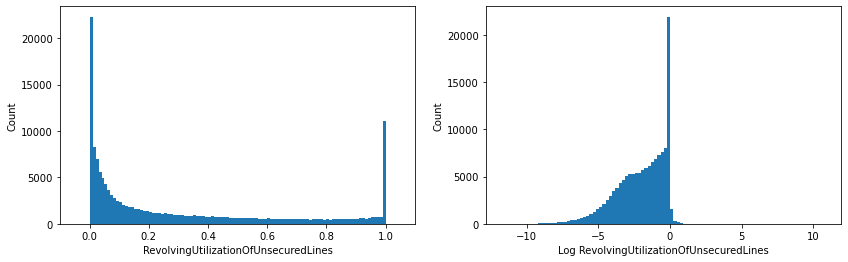

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

less_1_revolving = credit_data["RevolvingUtilizationOfUnsecuredLines"] <= 1
nonzero_revolving = credit_data["RevolvingUtilizationOfUnsecuredLines"] > 0

ax[0].hist(credit_data[less_1_revolving]["RevolvingUtilizationOfUnsecuredLines"],
         bins = 100)
ax[0].set_xlim([-0.1,1.1])
ax[0].set_xlabel("RevolvingUtilizationOfUnsecuredLines")
ax[0].set_ylabel("Count")

ax[1].hist(np.log(credit_data[nonzero_revolving]["RevolvingUtilizationOfUnsecuredLines"]),
         bins = 100)
ax[1].set_xlabel("Log RevolvingUtilizationOfUnsecuredLines")
ax[1].set_ylabel("Count")

plt.show()

In [59]:
prob_0 = (~nonzero_revolving).mean()
thres = 0.99999
around_1_revolving = (credit_data["RevolvingUtilizationOfUnsecuredLines"] > thres) &  (credit_data["RevolvingUtilizationOfUnsecuredLines"] <= 1)
prob_around_1 = around_1_revolving.mean()

print(f'Probability of 0 RevolvingUtilizationOfUnsecuredLines: {prob_0:1.3f}')
print(f'Probability of {thres}-1 RevolvingUtilizationOfUnsecuredLines: {prob_around_1:1.3f}')

Probability of 0 RevolvingUtilizationOfUnsecuredLines: 0.073
Probability of 0.99999-1 RevolvingUtilizationOfUnsecuredLines: 0.068


In [60]:
p = (flagged & ~less_1_revolving).mean()/(~less_1_revolving).mean()

print(f'Probability of Flagged customer, given greater than 1 RevolvingUtilizationOfUnsecuredLines: {p:1.3f}')

Probability of Flagged customer, given greater than 1 RevolvingUtilizationOfUnsecuredLines: 0.372


In [61]:
(~less_1_revolving).mean()

0.02214

## 5(c) Monthly Income

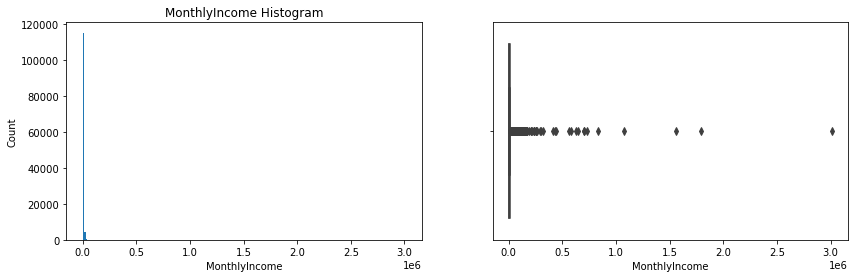

In [62]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(credit_data["MonthlyIncome"], bins = 200)
ax[0].set_title("MonthlyIncome Histogram")
ax[0].set_xlabel("MonthlyIncome")
ax[0].set_ylabel("Count")

ax[1] = sns.boxplot(data=credit_data, x='MonthlyIncome')

plt.show()

In [63]:
pers = (credit_data["TypeCustomer"]=='Personal')
zero_inc = (credit_data[pers]["MonthlyIncome"] == 0)
p = zero_inc.mean()

print(f'Probability of 0 income among Personal-type customers: {p:1.4f}')

Probability of 0 income among Personal-type customers: 0.0136


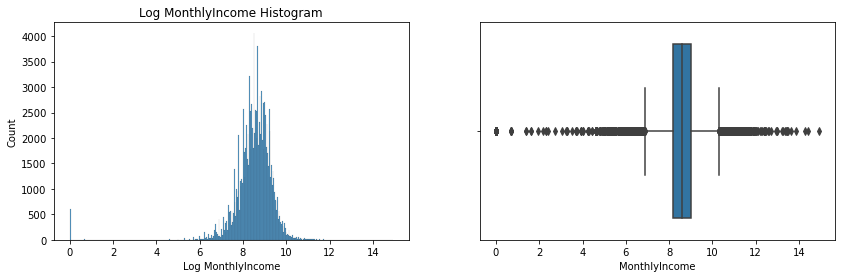

In [64]:
pers = (credit_data["TypeCustomer"]=='Personal')
non_zero_income = (credit_data["MonthlyIncome"] > 0) & (pers)
fig, ax = plt.subplots(1,2,figsize=(14,4))

log_income = np.log(credit_data[non_zero_income]["MonthlyIncome"])

sns.histplot(x=log_income, ax=ax[0])
ax[0].set_title("Log MonthlyIncome Histogram")
ax[0].set_xlabel("Log MonthlyIncome")
ax[0].set_ylabel("Count")

sns.boxplot(x=log_income, ax=ax[1])

plt.show()

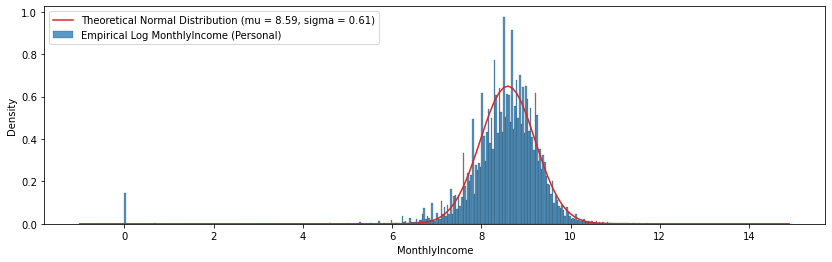

In [65]:
q1 = log_income.quantile(0.25)
q3 = log_income.quantile(0.75)
IQR = q3 - q1
lower = q1 - 1.5*IQR
upper = q3 + 1.5*IQR

inside_whisker = (log_income > lower) & (log_income < upper)

# create normal distribution plot

x_axis = np.arange(-1, 15, 0.1)

mean = log_income[inside_whisker].mean()
sd = log_income[inside_whisker].std()

cust = 'Personal'

plt.figure(figsize=(14,4))    
sns.histplot(x=log_income, stat='density', label=f'Empirical Log MonthlyIncome ({cust})')
plt.plot(x_axis, norm.pdf(x_axis, mean, sd), color='C3', label=f'Theoretical Normal Distribution (mu = {mean:1.2f}, sigma = {sd:1.2f})')
plt.legend()
plt.show()

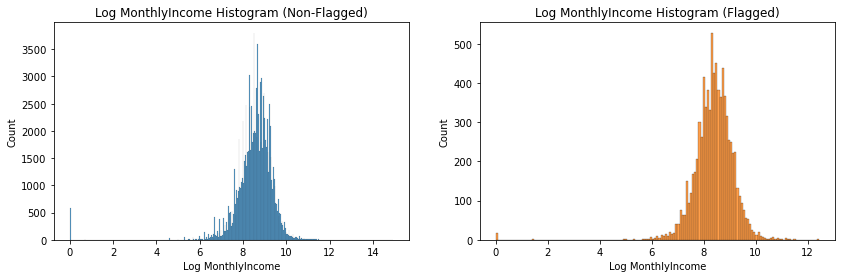

In [66]:
pers = (credit_data["TypeCustomer"]=='Personal')
non_zero_income = (credit_data["MonthlyIncome"] > 0) & (pers)
fig, ax = plt.subplots(1,2,figsize=(14,4))

for k, loan_status in enumerate(["Non-Flagged", "Flagged"]):

    status = (credit_data['SeriousDlqin2yrs'] == k)
    log_income = np.log(credit_data[non_zero_income & status]["MonthlyIncome"])

    sns.histplot(x=log_income, ax=ax[k], color=f'C{k}')
    ax[k].set_title(f'Log MonthlyIncome Histogram ({loan_status})')
    ax[k].set_xlabel("Log MonthlyIncome")
    ax[k].set_ylabel("Count")

plt.show()

# 6. Correlation Analysis

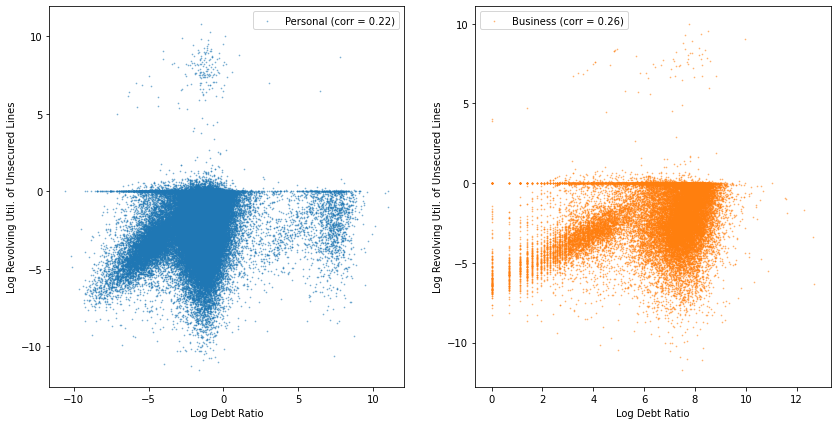

In [67]:
nonzero_revolving = credit_data["RevolvingUtilizationOfUnsecuredLines"] > 0

fig, ax = plt.subplots(1,2, figsize=(14,7))

for k, cust in enumerate(["Personal", "Business"]):

    cust_type = (credit_data["TypeCustomer"] == cust)

    x = np.log(credit_data[nonzero_dr & nonzero_revolving & cust_type]["DebtRatio"])
    y = np.log(credit_data[nonzero_dr & nonzero_revolving & cust_type]["RevolvingUtilizationOfUnsecuredLines"])
    corr = np.corrcoef(x,y)[0,1]
    ax[k].scatter(x=x, 
                  y=y,
                  s = 0.5,
                  alpha = 0.5,
                  label = f'{cust} (corr = {corr:1.2f})',
                  color = f'C{k}')
    ax[k].set_xlabel("Log Debt Ratio")
    ax[k].set_ylabel("Log Revolving Util. of Unsecured Lines")
    ax[k].legend()

plt.show()

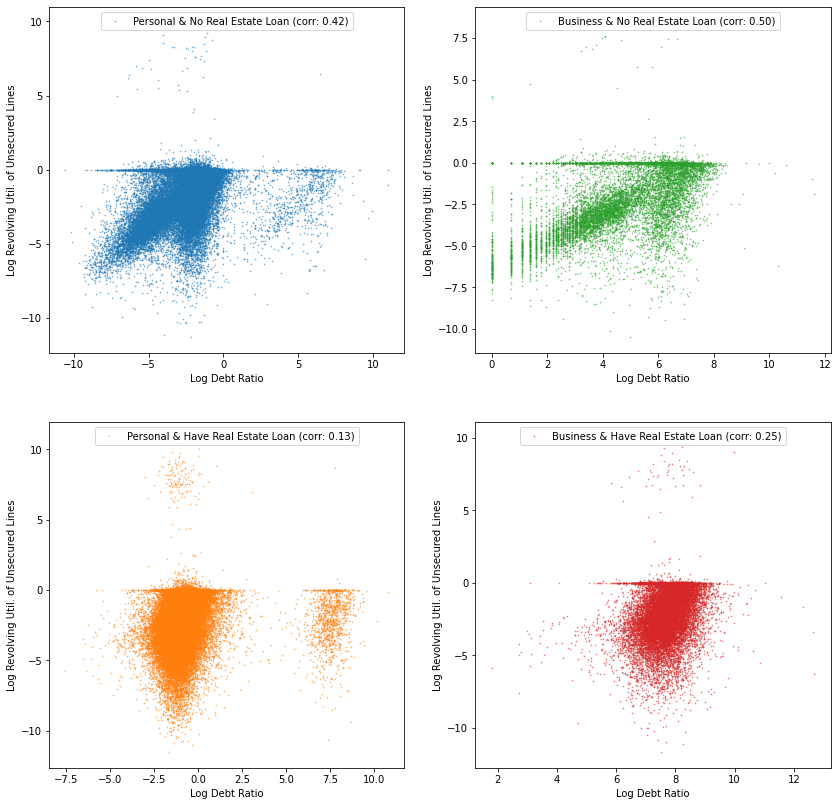

In [68]:
nonzero_num_real_est = credit_data["NumberRealEstateLoansOrLines"] > 0
zero_income = (credit_data["MonthlyIncome"] == 0)

fig, ax = plt.subplots(2,2, figsize=(14,14))

i = 0

for k, cust in enumerate(["Personal", "Business"]):
    
    for j, real_est_cond in enumerate([~nonzero_num_real_est, nonzero_num_real_est]):
        
        cust_type = (credit_data["TypeCustomer"] == cust)
        real_est_lab = lambda x: "No Real Estate Loan" if x==0 else "Have Real Estate Loan"
        
        x = np.log(credit_data[nonzero_dr & nonzero_revolving & real_est_cond & cust_type]["DebtRatio"])
        y=np.log(credit_data[nonzero_dr & nonzero_revolving & real_est_cond & cust_type]["RevolvingUtilizationOfUnsecuredLines"])
        corr = np.corrcoef(x,y)[0,1]
        
        ax[j,k].scatter(x=x, 
                        y=y,
                        s = 0.5,
                        alpha = 0.5,
                        label = f'{cust} & {real_est_lab(j)} (corr: {corr:1.2f})',
                        color = f'C{i}')
        ax[j,k].set_xlabel("Log Debt Ratio")
        ax[j,k].set_ylabel("Log Revolving Util. of Unsecured Lines")
        ax[j,k].legend(loc='upper center')
        i += 1

plt.show()

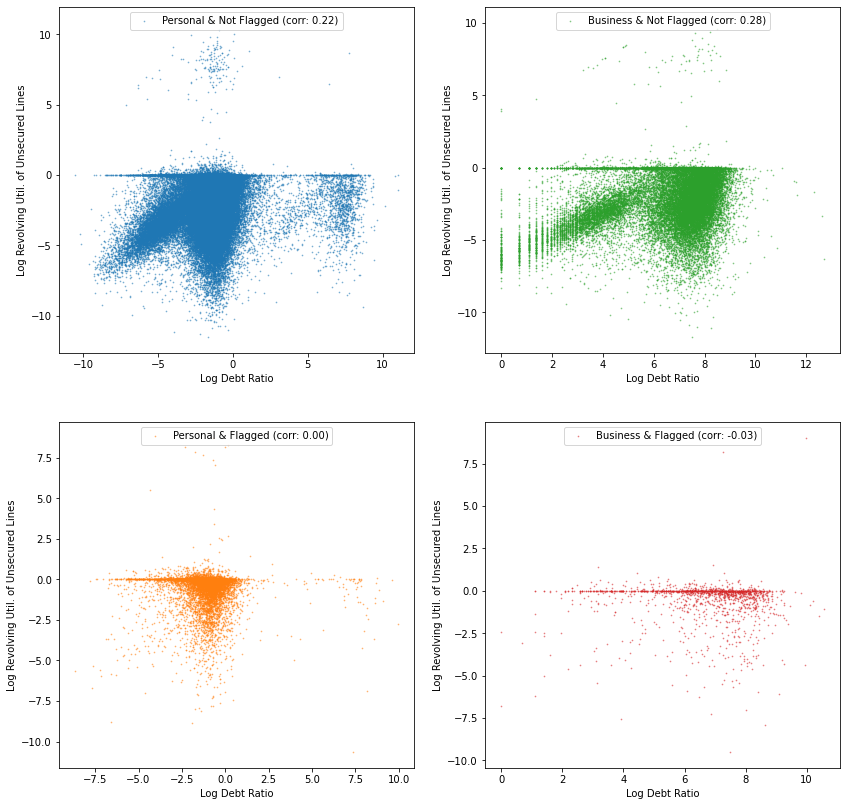

In [69]:
nonzero_num_real_est = credit_data["NumberRealEstateLoansOrLines"] > 0
zero_income = (credit_data["MonthlyIncome"] == 0)

fig, ax = plt.subplots(2,2, figsize=(14,14))

i = 0

for k, cust in enumerate(["Personal", "Business"]):
    
    for j, flag_cond in enumerate([~flagged, flagged]):
        
        cust_type = (credit_data["TypeCustomer"] == cust)
        flag_cond_lab = lambda x: "Not Flagged" if x==0 else "Flagged"
        
        x = np.log(credit_data[nonzero_dr & nonzero_revolving & flag_cond & cust_type]["DebtRatio"])
        y=np.log(credit_data[nonzero_dr & nonzero_revolving & flag_cond & cust_type]["RevolvingUtilizationOfUnsecuredLines"])
        corr = np.corrcoef(x,y)[0,1]
        
        ax[j,k].scatter(x=x, 
                        y=y,
                        s = 0.5,
                        alpha = 0.5,
                        label = f'{cust} & {flag_cond_lab(j)} (corr: {corr:1.2f})',
                        color = f'C{i}')
        ax[j,k].set_xlabel("Log Debt Ratio")
        ax[j,k].set_ylabel("Log Revolving Util. of Unsecured Lines")
        ax[j,k].legend(loc='upper center')
        i += 1

plt.show()

# 7. Hypothesis Testing

## Comparing the population mean of (log) DebtRatio for non-flagged vs flagged customers

In [70]:
for cust in ["Personal", "Business"]:
    
    print(f'{cust} TypeCustomer')
    cust_type = (credit_data["TypeCustomer"] == cust)
    
    # first, exclude outliers to compute sample means and variances

    log_debtratio = np.log(credit_data[nonzero_dr & cust_type]["DebtRatio"])

    q1 = log_debtratio.quantile(0.25)
    q3 = log_debtratio.quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR

    non_flagged_log_debtratio = np.log(credit_data[nonzero_dr & cust_type & ~flagged]["DebtRatio"])
    flagged_log_debtratio = np.log(credit_data[nonzero_dr & cust_type & flagged]["DebtRatio"])

    non_flagged_log_debtratio_iqr = non_flagged_log_debtratio[(non_flagged_log_debtratio > lower) & (non_flagged_log_debtratio < upper)]
    flagged_log_debtratio_iqr = flagged_log_debtratio[(flagged_log_debtratio > lower) & (flagged_log_debtratio < upper)]
    
    # First, test for variance equality

    n1 = non_flagged_log_debtratio_iqr.shape[0]
    n2 = flagged_log_debtratio_iqr.shape[0]

    s1 = non_flagged_log_debtratio_iqr.std()
    s2 = flagged_log_debtratio_iqr.std()

    F = (s1/s2)**2
    F_test_lower = stats.f.ppf(0.025, n1-1, n2-1)
    F_test_upper = stats.f.ppf(0.975, n1-1, n2-1)
    
    var_non_reject = (F >= F_test_lower) and (F <= F_test_upper)
    
    if var_non_reject:
        print('The null hypothesis (the variance of both populations are the same) failed to be rejected')
    else:
        print('The null hypothesis (the variance of both populations are the same) is rejected')
        
    # Then test for two-means equality for equal variance

    x1 = non_flagged_log_debtratio_iqr.mean()
    x2 = flagged_log_debtratio_iqr.mean()

    t = x1 - x2
    
    if var_non_reject:
        sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1 + n2 - 2))
        s = np.sqrt((sp**2)*((1/n1) + (1/n2)))
    else:
        s = np.sqrt((s1**2/n1) + (s2**2/n2))

    # for large sample, we just approximate t-distribution with standard normal
    test_lower = t - stats.norm.ppf(0.975)*s
    test_upper = t - stats.norm.ppf(0.025)*s

    if (t >= test_lower) and (t <= test_upper):
        print('The null hypothesis (the means of both populations are the same) failed to be rejected\n')
    else:
        print('The null hypothesis (the means of both populations are the same) is rejected\n')

Personal TypeCustomer
The null hypothesis (the variance of both populations are the same) is rejected
The null hypothesis (the means of both populations are the same) failed to be rejected

Business TypeCustomer
The null hypothesis (the variance of both populations are the same) is rejected
The null hypothesis (the means of both populations are the same) failed to be rejected



In [71]:
for cust in ["Personal"]:
    
    print(f'The mean of (Log) Monthly Income for Non-Flagged vs Flagged')
    cust_type = (credit_data["TypeCustomer"] == cust)
    
    # first, exclude outliers to compute sample means and variances

    log_income = np.log(credit_data[~zero_inc & cust_type]["MonthlyIncome"])

    q1 = log_income.quantile(0.25)
    q3 = log_income.quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR

    non_flagged_log_income = np.log(credit_data[~zero_inc & cust_type & ~flagged]["MonthlyIncome"])
    flagged_log_income = np.log(credit_data[~zero_inc & cust_type & flagged]["MonthlyIncome"])

    non_flagged_log_income_iqr = non_flagged_log_income[(non_flagged_log_income > lower) & (non_flagged_log_income < upper)]
    flagged_log_income_iqr = flagged_log_income[(flagged_log_income > lower) & (flagged_log_income < upper)]
    
    # First, test for variance equality

    n1 = non_flagged_log_income_iqr.shape[0]
    n2 = flagged_log_income_iqr.shape[0]

    s1 = non_flagged_log_income_iqr.std()
    s2 = flagged_log_income_iqr.std()

    F = (s1/s2)**2
    F_test_lower = stats.f.ppf(0.025, n1-1, n2-1)
    F_test_upper = stats.f.ppf(0.975, n1-1, n2-1)
    
    var_non_reject = (F >= F_test_lower) and (F <= F_test_upper)
    
    if var_non_reject:
        print('The null hypothesis (the variance of both populations are the same) failed to be rejected')
    else:
        print('The null hypothesis (the variance of both populations are the same) is rejected')
        
    # Then test for two-means equality for equal variance

    x1 = non_flagged_log_income_iqr.mean()
    x2 = flagged_log_income_iqr.mean()

    t = x1 - x2
    
    if var_non_reject:
        sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1 + n2 - 2))
        s = np.sqrt((sp**2)*((1/n1) + (1/n2)))
    else:
        s = np.sqrt((s1**2/n1) + (s2**2/n2))

    # for large sample, we just approximate t-distribution with standard normal
    test_lower = t - stats.norm.ppf(0.975)*s
    test_upper = t - stats.norm.ppf(0.025)*s

    if (t >= test_lower) and (t <= test_upper):
        print('The null hypothesis (the means of both populations are the same) failed to be rejected\n')
    else:
        print('The null hypothesis (the means of both populations are the same) is rejected\n')

The mean of (Log) Monthly Income for Non-Flagged vs Flagged
The null hypothesis (the variance of both populations are the same) failed to be rejected
The null hypothesis (the means of both populations are the same) failed to be rejected

